# PIX2PIX


Pix2pix je metoda mapiranja slika iz jednog skupa podataka u drugi skup podataka. Metoda se zasniva na uslovljenim generativnim suparničkim mrežama. Iako je i pre bilo pokušaja da se mapiraju slike iz jedne u drugu, ovo je jedan od prvih pokušaja da se upotrebi mašinsko učenje za prebacivanje slika iz jednog u drugi stil. Ovaj metod nije prvi koji pokušava da reši ovaj problem, ali je on jedan od prvih koji ne zahteva nikakve dodatne mašine specijalne namere za rešavanje ovog problema. Jedino što je potrebno ovoj metodi je da ima uparen skupove podataka ( što je mana ove metode ) da bi pokušao da reši ovaj problem. Naravno od kvaliteta podataka i složenosti samog modela zavisi i kvalitet rešenja. Jedan od problema koji je rešavan ovom metodom jeste prebacivanje slike iz ptičije perspektive u mapu. Rezultate tog eksperimenta su prikazani na sledećoj slici.

<img src="images/aerial-to-map.png"  width="400" hight="700" align="left">

## U-Net
Za generator se koristi enkoder-dekoder arhitektura. U ovoj metodi se koristi U-Net, modifikovana verzija enkoder-dekoder arhitekture sa preskočenim vezama simetričnih slojeva. Generalna zamisao je da spojimo neke slojeve da bismo sačuvali neke informacije pre nego što ih izgubimo prilikom **downsampling-a** . U ovoj radnoj svesci nećemo koristi arhitekturu iz metode pix2pix da bismo samo pokazali funkcionalnost ove metode i sa jednostavnijim mrežama.

<img src="images/u-net.png"  width="600" hight="700" align="left">

## PatchGAN

Ideja je da diskriminator ne uzima u obzir celu sliku, već da klasifikuje samo neke delove slike (Patch) pod pretopstavkom da su pikseli dovoljno udaljeni jednih od drugih. Na slici ispod se nalazi poređenje različitih dimenzija delova slika (Patch) i njihovih rezultata. Sa manjom dimenzijom prozora se podstiče veći diverzitet boja, a sa većim dimenzijama prozora se dobija bolji kvalitet slike.

<img src="images/patchgan.png"  width="1000" hight="900" align="left">

U ovoj svesci biće prikazana metoda pix2pix na skupu podataka fashin_mnist uz dodavanje dodatnog šuma.

In [1]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from IPython import display
import torch

In [2]:
(train_images,_), (test_images,_) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
assert train_images.shape == (60000, 28, 28)
assert test_images.shape == (10000,28,28) 

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalizovanje slika

In [5]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalizovanje slika

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 1

In [7]:
def duplicate_image(image):
    return image, image

In [8]:
def salt_and_pepper(image, prob_salt=0.1, prob_pepper=0.1):
    random_values = tf.random.uniform(shape=image[0, ..., -1:].shape)
    image = tf.where(random_values < prob_salt, 1., image)
    image = tf.where(1 - random_values < prob_pepper, 0., image)
    return image

In [9]:
# Ovde ide dodavanje noise
def add_noise(image):
    noisy_image = salt_and_pepper(image)
    return noisy_image, image

In [10]:
noisy_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(add_noise).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(add_noise).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
# dimenyije slike
IMG_WIDTH = 28
IMG_HEIGHT = 28


In [12]:
def Generator():
    
    initializer = tf.random_normal_initializer(0.,0.12)
    inputs = tf.keras.layers.Input(shape=[28,28,1])
    
    conv2d_1 = tf.keras.layers.Conv2D(16,3,strides=2,kernel_initializer=initializer,padding='same')(inputs)
    conv2d_2 = tf.keras.layers.Conv2D(16,3,strides=2,kernel_initializer=initializer,padding='same')(conv2d_1)
    conv2dT = tf.keras.layers.Conv2DTranspose(16,3,strides=2,kernel_initializer=initializer,padding='same')(conv2d_2)
    tmp = tf.keras.layers.Concatenate()([conv2d_1,conv2dT])
    
    last = tf.keras.layers.Conv2DTranspose(1,4,strides=2,kernel_initializer=initializer,padding='same',activation='tanh')(tmp)
    
    return tf.keras.Model(inputs=inputs,outputs=last)

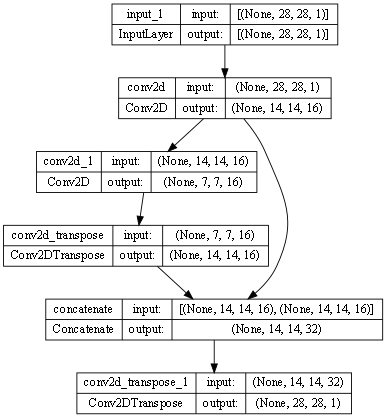

In [13]:
generator = Generator()
tf.keras.utils.plot_model(generator,to_file="./models/02-pix2pix/generator.png",show_shapes=True,dpi=64)

In [14]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 16)     2320        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 14, 14, 16)  2320        ['conv2d_1[0][0]']               
 ose)                                                                                         

Diskriminator ima dva ulazna sloja, jedan sloj dobija za ulaz generisanu sliku dok drugi sloj dobija ciljanu sliku, tj. onu u koju treba da prebacimo prvu sliku.

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.12)
    
    inp = tf.keras.layers.Input(shape=[28,28,1],name="input_image")
    tar = tf.keras.layers.Input(shape=[28,28,1],name="target_image")   
    
    x = tf.keras.layers.concatenate([inp,tar])
    
    layer1 = tf.keras.layers.Conv2D(16,4,strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False)(x)
    layer2 = tf.keras.layers.Conv2D(16,4,strides=2,padding='same',
                              kernel_initializer=initializer,use_bias=False)(layer1)
    last  = tf.keras.layers.Conv2D(1,4,strides=1)(layer2)
    
    return tf.keras.Model(inputs=[inp,tar],outputs=last)

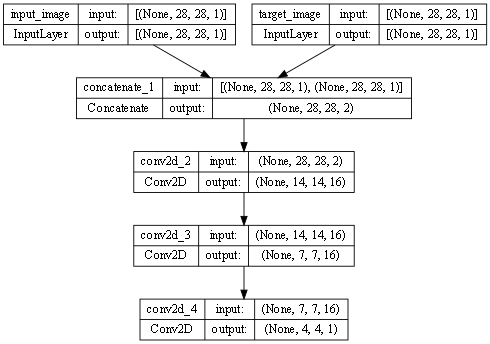

In [16]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator,to_file="./models/02-pix2pix/diskriminator.png",show_shapes=True,dpi=64)

In [17]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 target_image (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 28, 28, 2)    0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']           
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 16)   512         ['concatenate_1[0][0]']    

In [18]:
LAMBDA = 10

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Obučavanje generatora izgleda ovako.
-  generisana slika se uporedjuje sa ciljnom promenljivom i računa se srednje kvadratna greškam jer želimo preslikamo ulaznu sliku da što više liči na ciljanu
-  ulazna slika se prosledjuje diskriminatoru koji procenjuje da li je ona prava ili generisana slika(tj njenji delovi) i vrši se uporedjivanje sa nizom jedinica jer želimo da klasifikator nauči da je označi da je generisana
-  na kraju se izračunaju gradijenti i primene se na generator

<img src="images/generator_pix2pix.png"  width="400" hight="400">

In [20]:
def generator_loss(disc_generated_output,gen_output,target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

Diskriminator je konvolutivni PatchGAN klasifikator. On pokusava da klasifikuje da li je svaki NxN deo  slike pravi ili generisani.
- svaki blok u diskriminatoru se sastoji od : konvulitivnog dela ->unutrasnje standardizacije ->Leaky ReLu
- diskriminator prima 2 ulaza:
     - ulazna slika i ciljna slika koja bi trebala da bude klasifikovana kao prava
     - ulazna slika i generisana slika koja bi trebalo da bude klasifikovana kao lazna
     - ova dva ulaza se spajaju u jedan koriscenjem tf.concat metode

In [21]:
def discriminator_loss(disc_real_output,disc_generated_output):
    real_loss= loss_object(tf.ones_like(disc_real_output),disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)
    
    total_loss = real_loss+generated_loss
    
    return total_loss

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [23]:
checkpoint_dir = './checkpoints/02-pix2pix/train'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator= discriminator)

In [24]:
def generate_images(model,test_input,tar):
    prediction = model(test_input,training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0],tar[0],prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5,cmap='gray')
        plt.axis('off')
        
    plt.show()

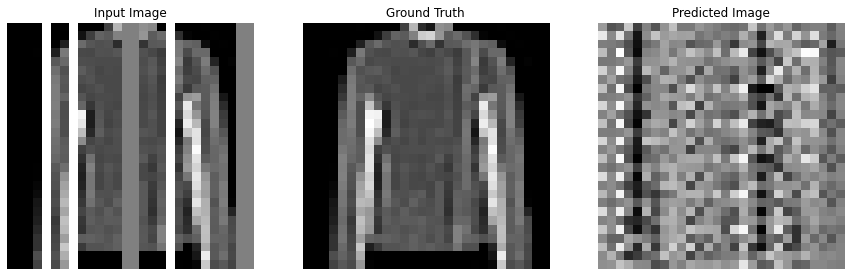

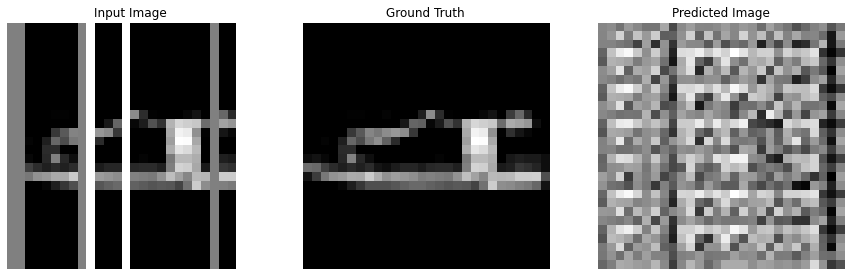

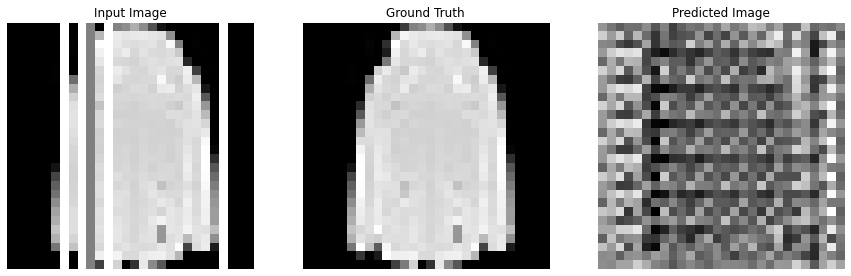

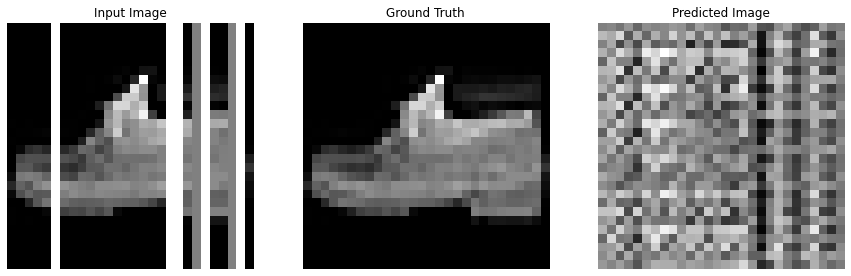

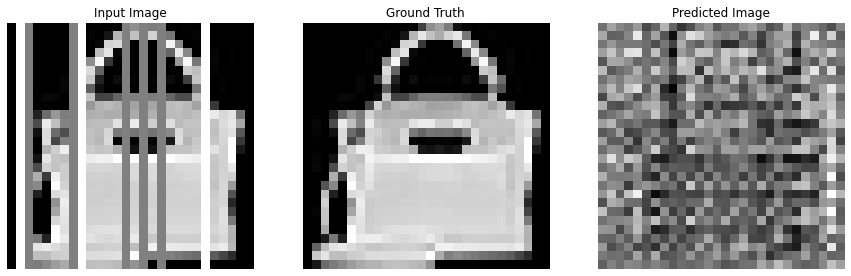

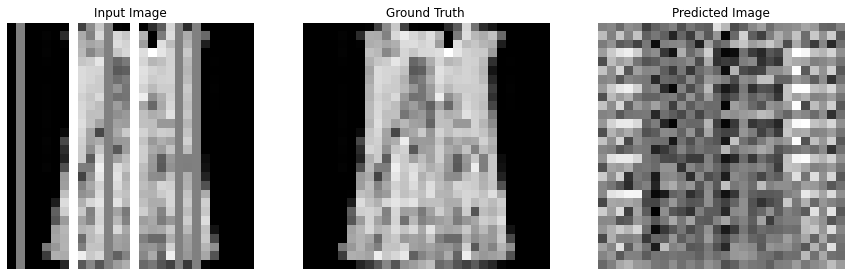

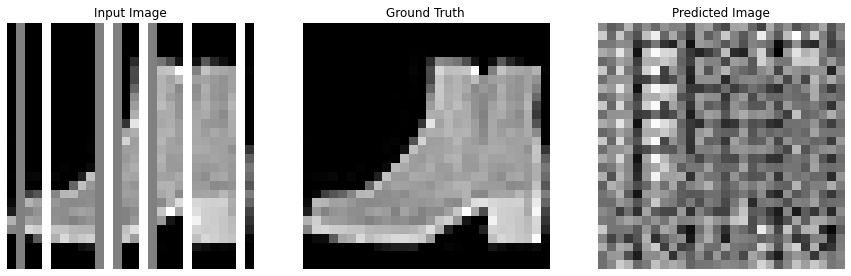

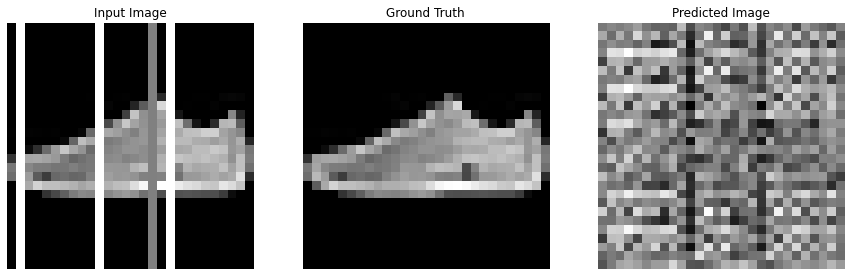

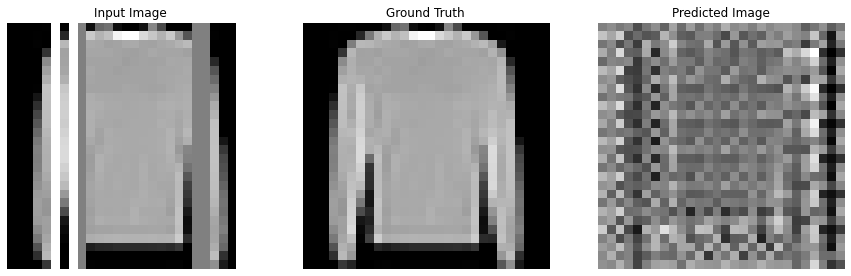

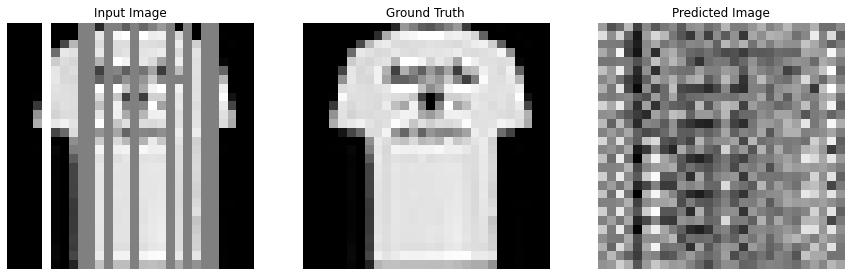

In [25]:
for example_input, example_target in noisy_dataset.take(10):
    generate_images(generator,example_input,example_target)

In [26]:
log_dir = "logs/"

summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
@tf.function
def train_step(input_image,target,step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image,training=True)
        
        disc_real_output = discriminator([input_image,target],training=True)
        disc_generated_output = discriminator([input_image,gen_output],training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',gen_total_loss,step= step//1000)
        tf.summary.scalar('gen_gan_loss',gen_gan_loss,step= step//1000)
        tf.summary.scalar('gen_l1_loss',gen_l1_loss,step= step//1000)
        tf.summary.scalar('disc_loss',disc_loss,step= step//1000)
    return  gen_total_loss , gen_gan_loss , gen_l1_loss , disc_loss
        

In [28]:
gen_total_loss_list = []
gen_gan_loss_list = []
gen_l1_loss_list = []
disc_loss_list=[]

In [29]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    i=0
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (i % 1000 == 0):
            display.clear_output(wait=True)

            if i != 0:
                print(f'Vreme potrebno  za 1000 koraka: {time.time()-start:.2f} sekundi\n')

            start = time.time()
        
            generate_images(generator, example_input, example_target)
            print(f"Korak: {i//1000}.")
        i = i+1
        gen_total_loss , gen_gan_loss , gen_l1_loss , disc_loss = train_step(input_image, target, step)
        # čuvamo samo 1000-tu vrednost gubitka da bismo imali lepši grafik
        if(i % 1000==0):
            gen_total_loss_list.append(gen_total_loss)
            gen_gan_loss_list.append(gen_gan_loss)
            gen_l1_loss_list.append(gen_l1_loss)
            disc_loss_list.append(disc_loss)
    
        if (i+1) % 10 == 0:
            print('.', end='', flush=True)


    # Čuvanje sveske na 5000 koraka
        if (i + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

Vreme potrebno  za 1000 koraka: 4.81 sekundi



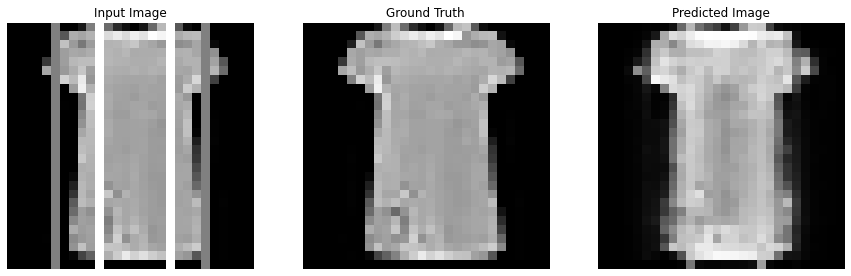

Korak: 39.
....................................................................................................

In [30]:
fit(noisy_dataset,noisy_dataset,steps=40000)

Proveravamo kako generator preslikava slike sa šumom u slike bez šuma. Vidimo da se poprilično dobro rešava šuma, dok ipak sliku nije savršeno naslikao.

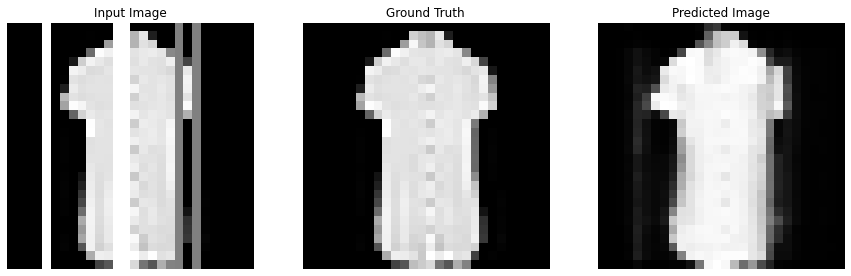

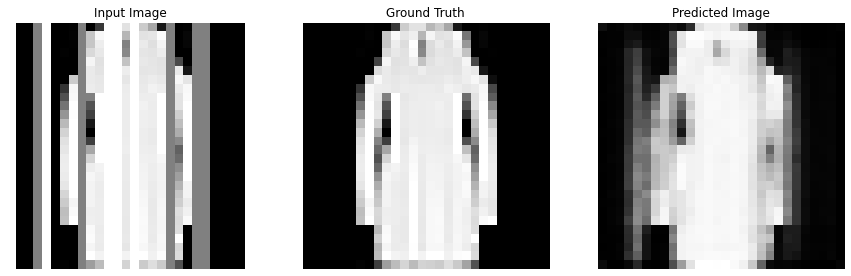

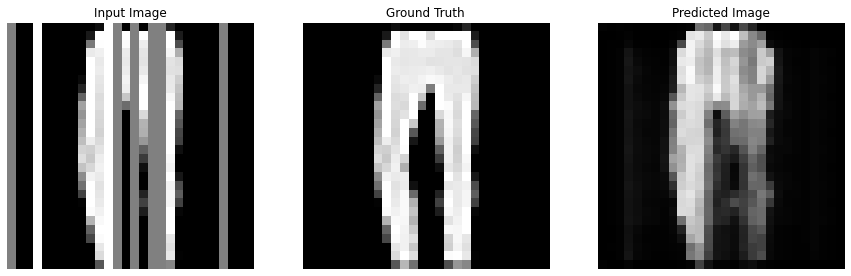

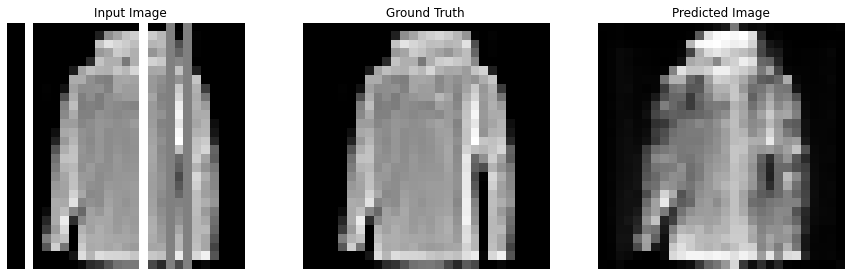

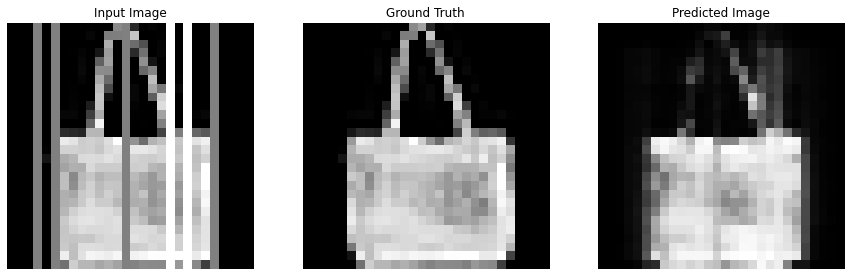

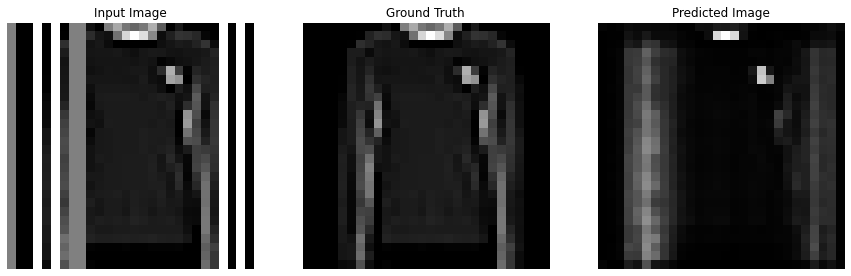

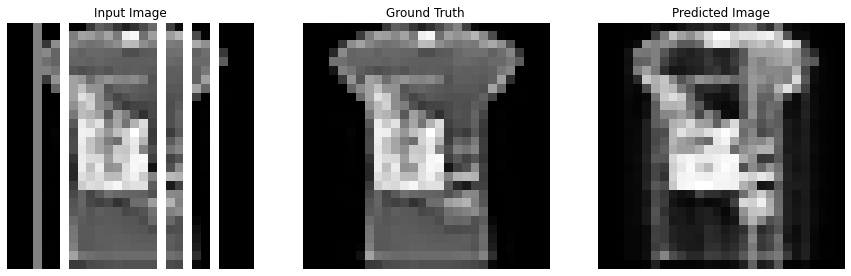

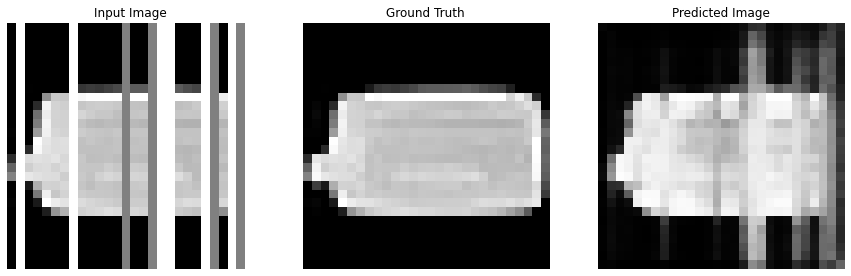

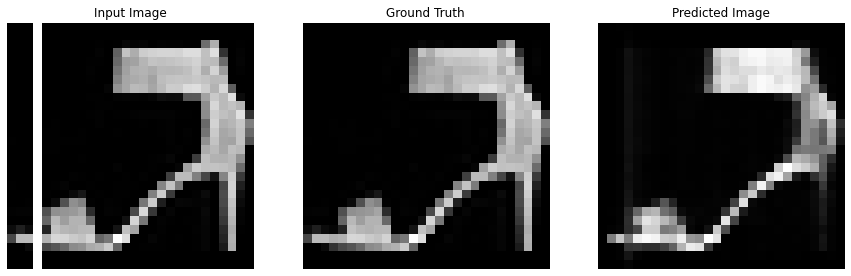

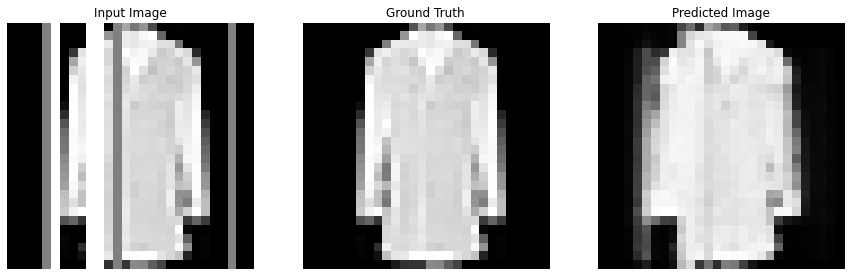

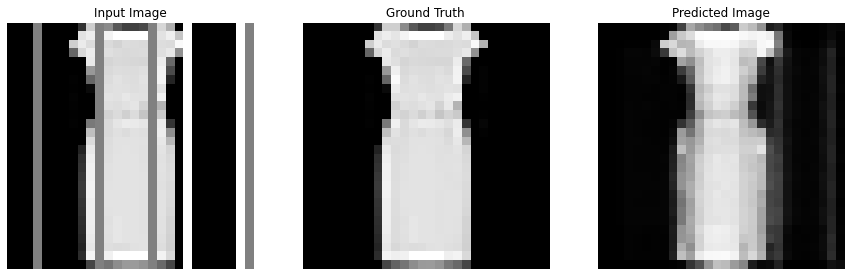

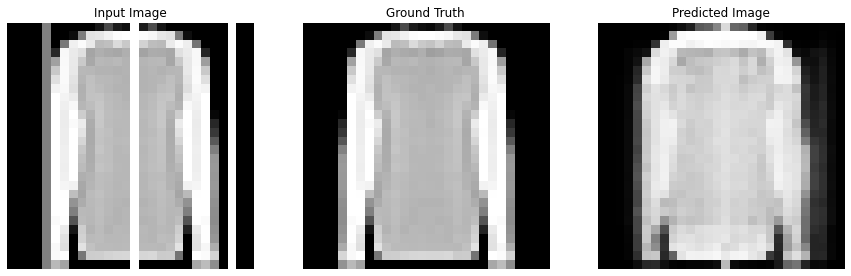

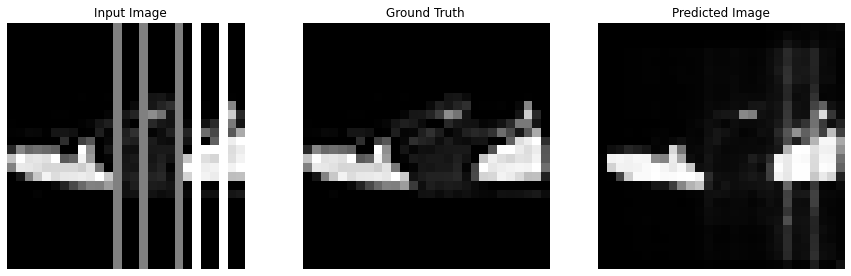

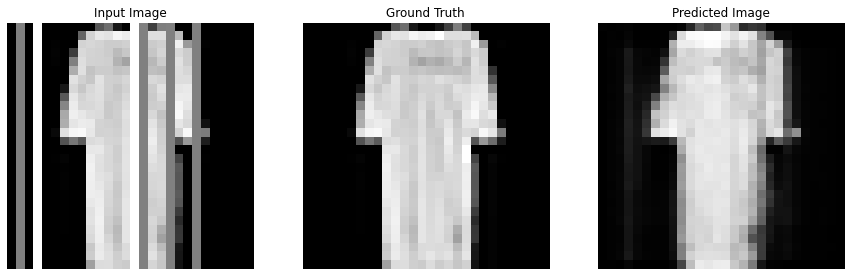

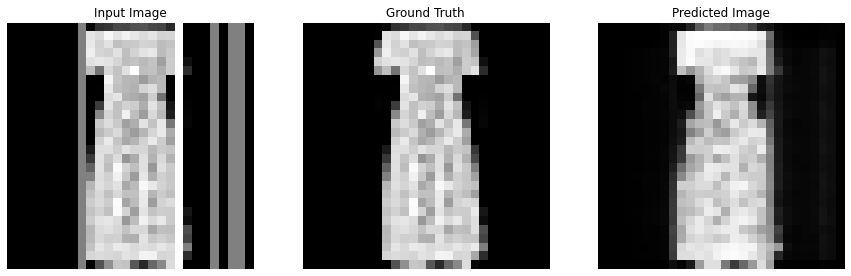

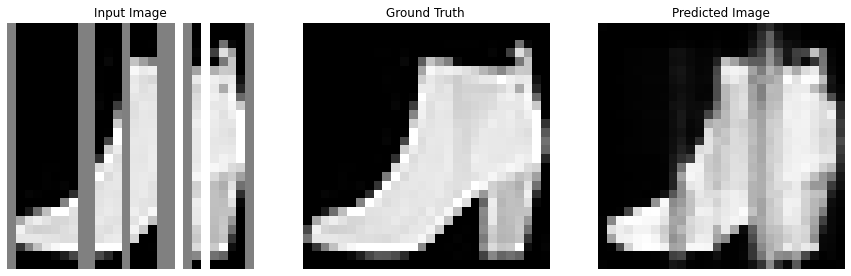

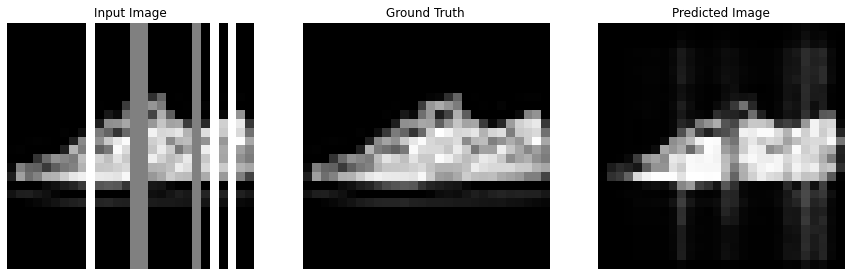

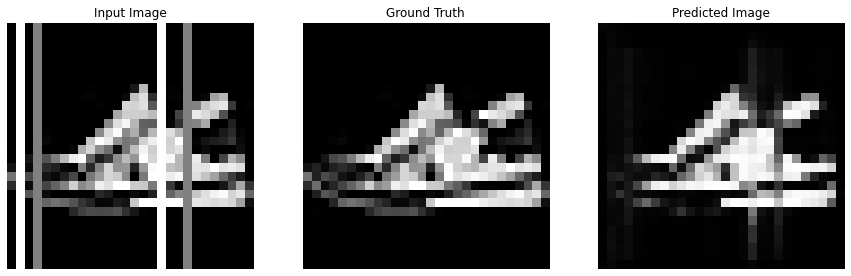

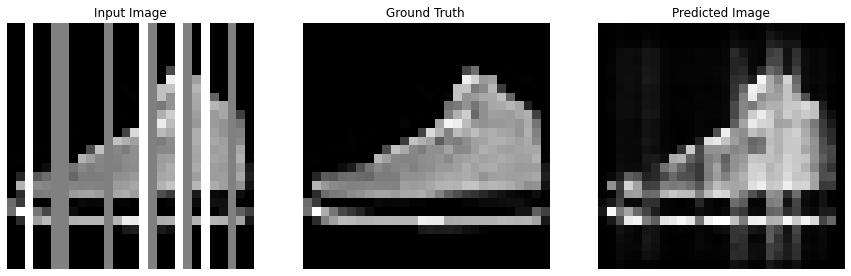

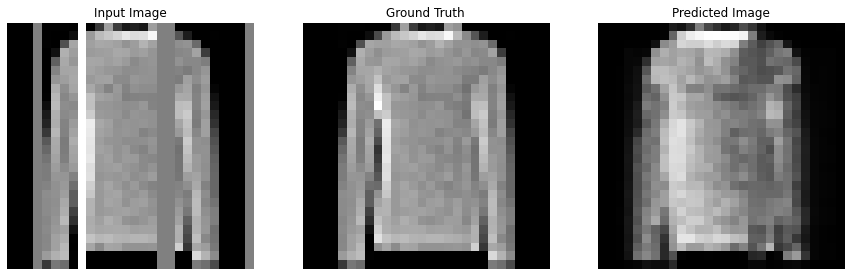

In [31]:
for inp, tar in noisy_dataset.take(20):
    generate_images(generator, inp, tar)

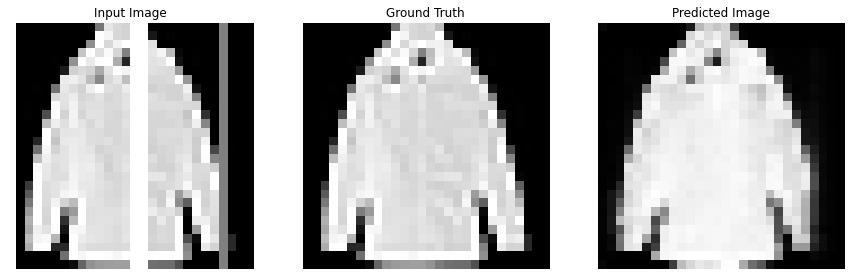

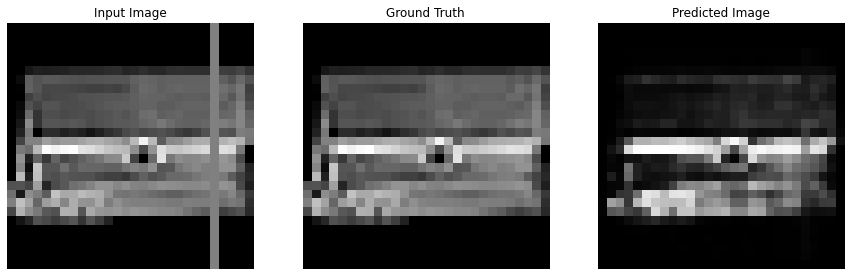

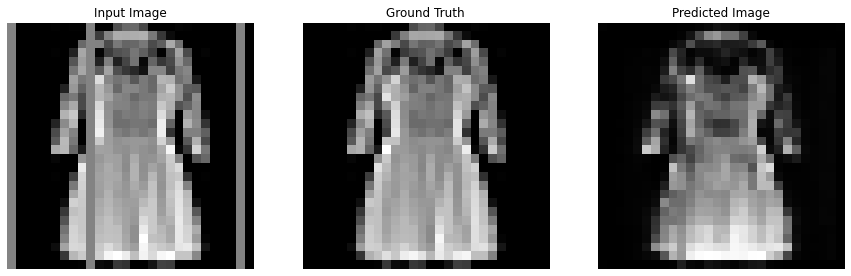

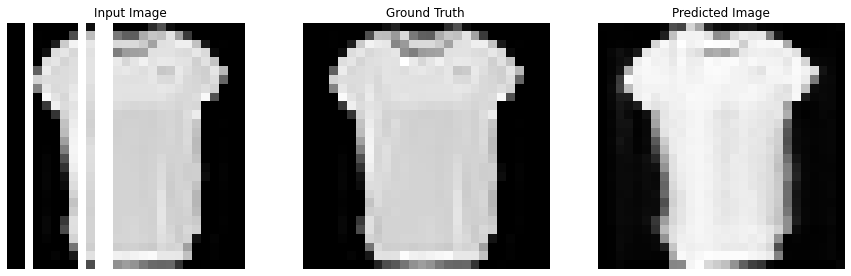

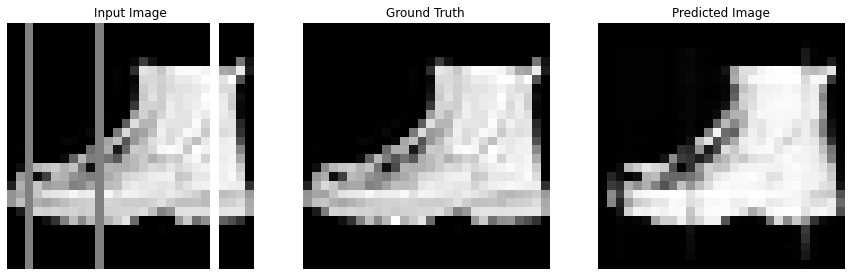

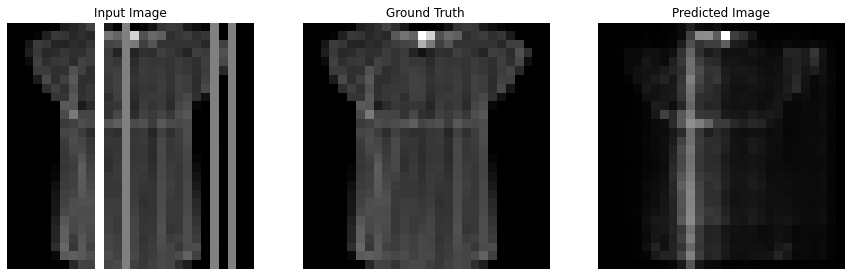

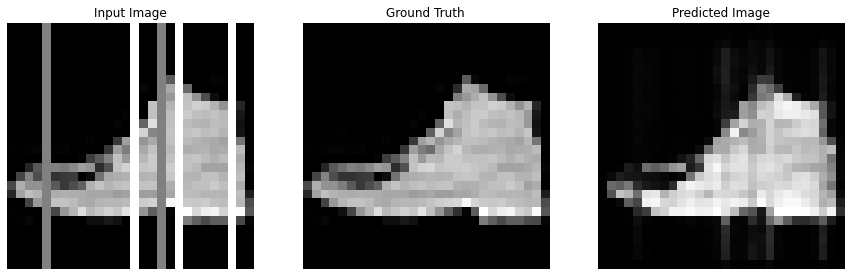

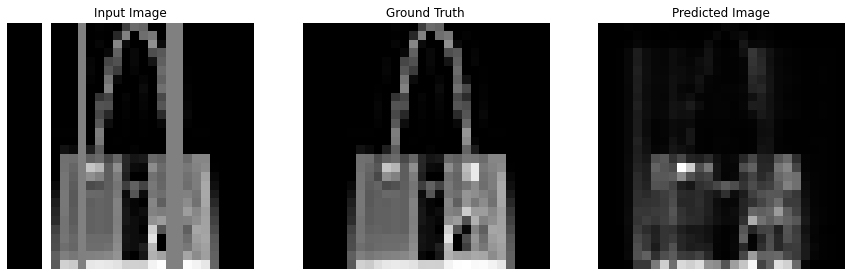

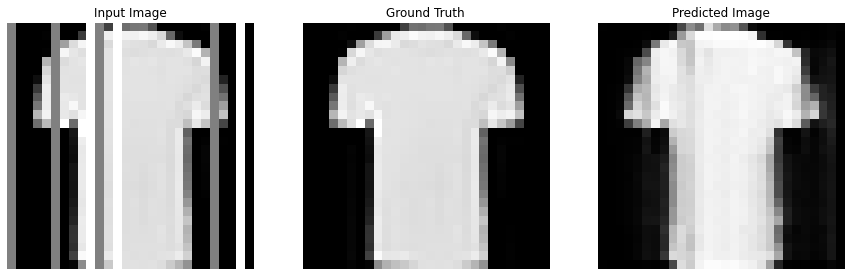

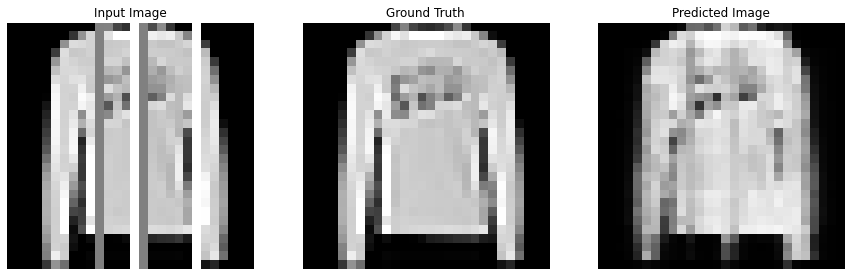

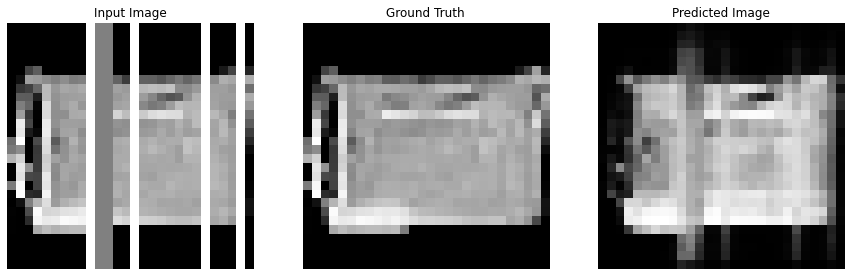

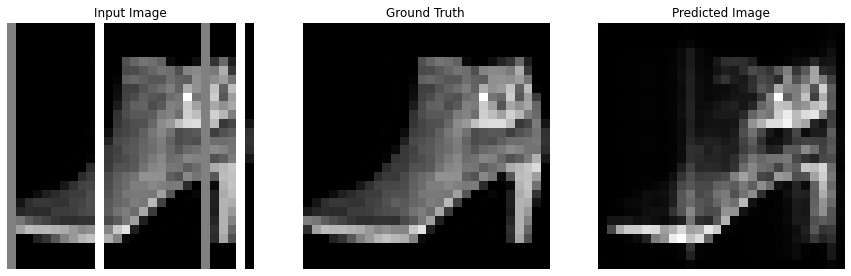

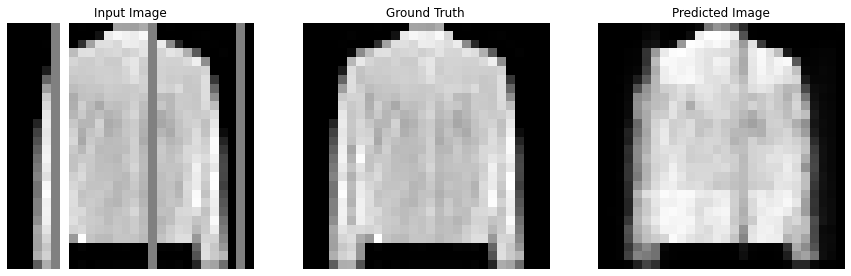

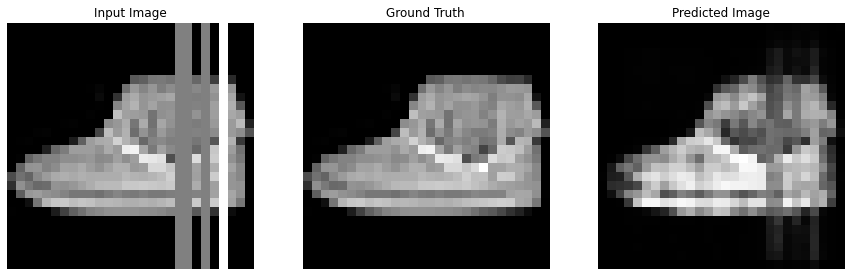

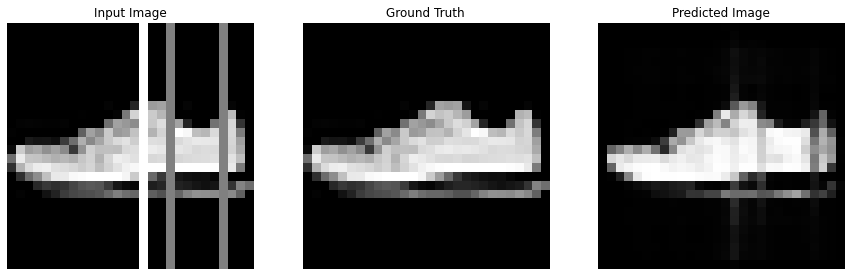

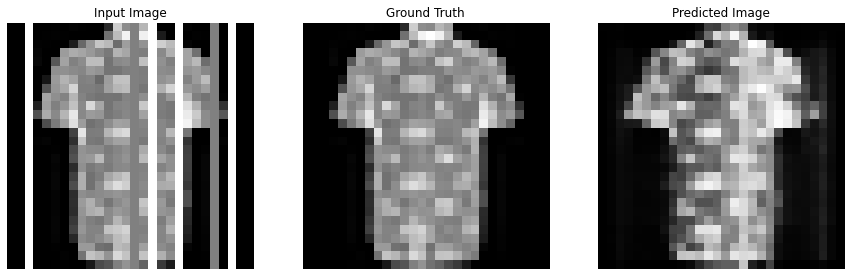

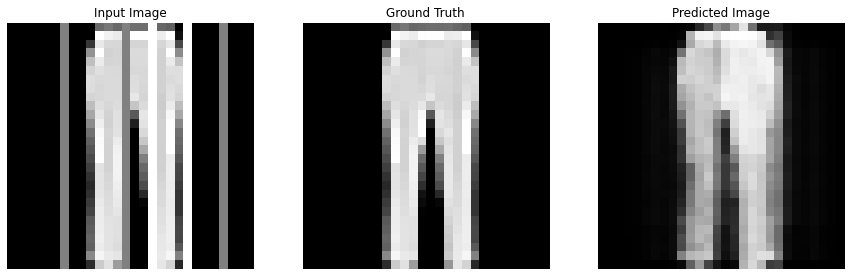

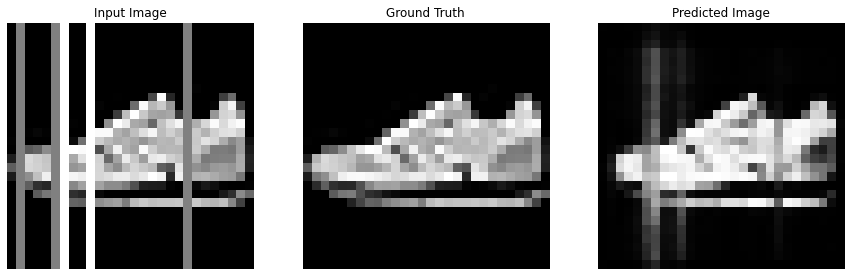

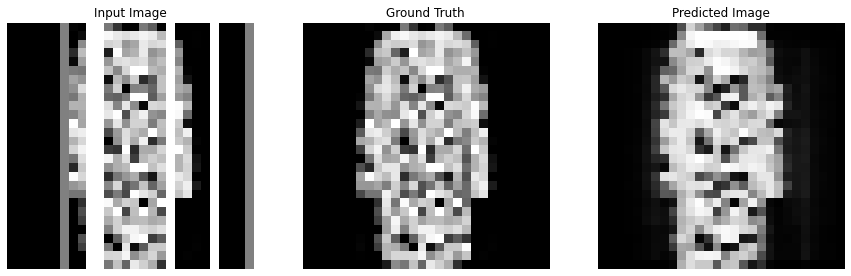

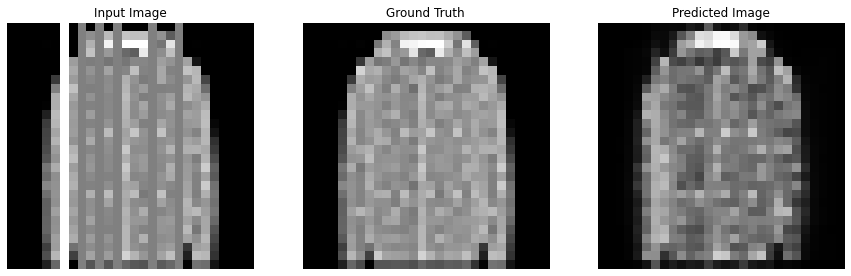

In [35]:
for inp, tar in test_dataset.take(20):
    generate_images(generator, inp, tar)

Prikazivanje grafika gubitka za generator i diskriminator. Vidimo da iz grafika generator poprilično dobro preslikava, tj. postoji mala razlika izmedju generisane slike i ciljne slike, medjutim diskriminator i dalje poprilično lako uspeva da prepozna da je ta slika generisana. a ne prava. 

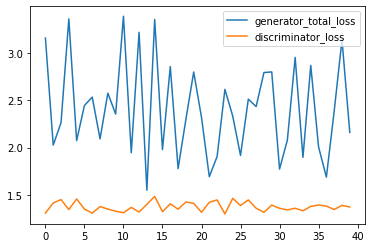

In [32]:
plt.title('')
plt.plot(np.arange(0, len(gen_gan_loss_list)), gen_total_loss_list,label="generator_total_loss")
plt.plot(np.arange(0, len(gen_gan_loss_list)), disc_loss_list,label="discriminator_loss")
plt.legend(loc='best')

plt.show()

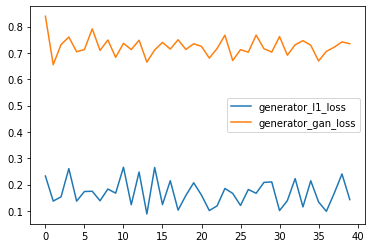

In [33]:
plt.title('')
plt.plot(np.arange(0, len(gen_gan_loss_list)), gen_l1_loss_list,label="generator_l1_loss")
plt.plot(np.arange(0, len(gen_gan_loss_list)), gen_gan_loss_list,label="generator_gan_loss")
plt.legend(loc='best')

plt.show()

In [34]:
generator.save('models/02-pix2pix/generator.h5')
discriminator.save('models/02-pix2pix/discriminator.h5')